## Left Ventricular Analysis

In [1]:
from __future__ import division, print_function

%matplotlib inline
from collections import OrderedDict
from warnings import warn, filterwarnings
filterwarnings('ignore', module='matplotlib')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import expit
import peakutils

Read and clean the source spreadsheets for the volumes time series and the recorded average R-R intervals. Build a dictionary of dataframes consisting of indexed time series for LV volumes.  

In [2]:
volumes = 'FullVolumes_Healthy.xlsx'
rrintervals = 'RRIntervals_Healthy.xlsx'

df_vols = pd.read_excel(volumes)
df_rrintervals = pd.read_excel(rrintervals).reset_index(drop=True)
df_rrintervals.index = ['RR']

# clean column names
df_vols = df_vols.rename(columns=lambda x: x[:6])
df_rrintervals = df_rrintervals.rename(columns=lambda x: x[:6])

# select columns to use
df_lv = df_vols.filter(regex='LV-[0-9]{3,3}$')
df_times = df_rrintervals.filter(regex='LV-[0-9]{3,3}$').T

# map index in rr times to integers
df_times['PN'] = [int(i[-3:]) for i in df_times.index]
df_times = df_times.set_index('PN')

# assume a fixed number of time points
nrows = df_lv.count(axis=0)[0]
df_times['dT'] = df_times['RR'] / nrows

patients = {}
for patno in [int(col[-3:]) for col in df_lv]:
    if any(pd.isnull(df_lv['LV-%03d' % patno])):
        warn("Wrong number of time points in Patient %s - ignoring." % patno)
        continue
    patients[patno] = pd.concat([
        pd.Series(np.arange(nrows) * df_times['dT'][patno], name='Time'),
        df_lv['LV-%03d' % patno],
    ], axis=1).set_index('Time')
    patients[patno].columns = ('LV',)
    patients[patno].pat_name = 'Patient %d' % patno

In [3]:
class LVAnalysis:
    """
    Extraction of parameters from LV volume curves.
    """
    SGWINLEN = 5
    SGPOLY = 2
    INTERP = 3    
    def __init__(self, volumes, times, name):
        
        # smooth curve and generate derivative curve using savitsky-golay filter
        sg_volumes = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN,
            polyorder=self.SGPOLY,
            mode='interp'
        )
        dt_msecs = np.mean(np.diff(times))
        
        # we'll fudge the boundary behaviour to make the identification of the 
        # late filling a bit more robust.
        sg_derivatives = 0.75 * savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+2,
            polyorder=self.SGPOLY+1,
            deriv=1,
            mode='interp',
            delta=dt_msecs
        ) + 0.25 * savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+2,
            polyorder=self.SGPOLY+1,
            deriv=1,
            mode='mirror',
            delta=dt_msecs
        )
        
        # acceleration is not used near the boundaries so it doesn't matter 
        sg_accelerations = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+4,
            polyorder=self.SGPOLY+2,
            deriv=2,
            mode='interp',
            delta=dt_msecs
        )

        self.times = times
        self.units, self.time_units = 'ml', 'ms'
        self.name = name
    
        # Interpolate in these
        spline_vols = InterpolatedUnivariateSpline(times, sg_volumes)
        spline_derivs = InterpolatedUnivariateSpline(times, sg_derivatives)
        spline_accels = InterpolatedUnivariateSpline(times, sg_accelerations)

        self.times   = np.linspace(0, times[-1], len(times)*self.INTERP)
        self.volumes = spline_vols(self.times)
        self.derivatives  = spline_derivs(self.times)
        self.accels  = spline_accels(self.times)

        self._es_index = np.argmin(self.volumes)
        self._idx_max_systolic_down_slope = (-self.derivatives[:self._es_index]).argmax()
        self._idx_max_recovery_slopes = self.calc_idx_max_recovery_slopes()


    def calc_idx_max_recovery_slopes(self):
        """
        Find locations of two distict maximum positive slopes in refilling phase.
        Tried using the wavelet based find_peaks_cwt but didn't seem reliable.
        Now using the peakutils packege (from pypi)
        """
        # nudge a bit past ES to avoid finding any wobble near the bottom of the curve 
        esi = self._es_index
        start = esi + 2*self.INTERP
        recovery = self.derivatives[start:]
        
        rolloff = self.derivatives[-1] * expit(np.arange(2*self.INTERP, -2*self.INTERP, -1))
        recovery = np.r_[recovery, rolloff]
        peaks = peakutils.indexes(recovery, thres=0.3, min_dist=3*self.INTERP)
        if len(peaks) >= 2:
            # sort first on height (of the derivative) and take the highest two
            peaks = sorted(peaks, key=lambda peak: recovery[peak])
            peaks = peaks[-2:]
            # this should give us the maximum slopes, which we'll now sort on time
            # to decide which is the early one
            peaks = sorted(peaks)
            # if the second one is found right at the end
            if peaks[1] >= len(self.derivatives) - start:
                # then use the point before last as a better estimate (a fudge)
                warn("Second filling peak right at end in %s - using slope one time point earlier." % self.name)
                peaks[1] = len(self.derivatives) - start - 2
            return peaks[0] + start, peaks[1] + start
        elif len(peaks) == 1:
            # fall back to just splitting recovery in half and finding separate maxima
            # warn("Only one filling peak found in %s - looking forward from there for second peak." % self.name)
            first_pk_index = peaks[0] + start
            accels = self.accels[first_pk_index:]
            slopes = self.derivatives[first_pk_index:]
            # location of maximum (negative) curvature
            curvature = accels * (1 + slopes**2)**(-1.5)
            curvature_peaks = peakutils.indexes(curvature, thres=0.2, min_dist=3*self.INTERP)
            if len(curvature_peaks) > 0:
                shoulder_idx = first_pk_index + curvature_peaks[0]
            else:
                shoulder_idx = first_pk_index + (-curvature).argmax()
            
            late_peaks = peakutils.indexes(self.derivatives[shoulder_idx:], thres=0.2, min_dist=3*self.INTERP)
            if len(late_peaks) > 0:
                return peaks[0] + start, late_peaks[0] + shoulder_idx
            else:
                warn("Second filling peak not found in %s - falling back to argmax." % self.name)
                return peaks[0] + start, shoulder_idx + self.derivatives[shoulder_idx:].argmax()
        else:
            # fall back to just splitting recovery in half and finding separate maxima
            warn("Can't find any filling peaks in %s - falling back to splitting recovery time in half." % self.name)
            edvol = self.volumes[-1]
            esvol = self.volumes[self._es_index]
            partfullvol = esvol + (edvol - esvol) * 0.5
            split_idx = np.where(self.volumes[esi:] - partfullvol >= 0)[0][0] + esi
            early_pk_idx = self.derivatives[esi:split_idx].argmax() + esi
            late_pk_idx = self.derivatives[split_idx:].argmax() + split_idx
            return early_pk_idx, late_pk_idx

    @property
    def es_time(self):
        return self.times[self._es_index]
    @property
    def emptying_time(self):
        return self.times[self._idx_max_systolic_down_slope]
    @property
    def emptying_vol(self):
        return self.volumes[self._idx_max_systolic_down_slope]
    @property
    def emptying_slope(self):
        return self.derivatives[self._idx_max_systolic_down_slope]
    @property
    def emptying_accel(self):
        return self.accelerations[self._idx_max_systolic_down_slope]

    @property
    def _early_filling_index(self):
        return self._idx_max_recovery_slopes[0]
    @property
    def _late_filling_index(self):
        return self._idx_max_recovery_slopes[1]

    @property
    def early_filling_time(self):
        return self.times[self._early_filling_index]
    @property
    def late_filling_time(self):
        return self.times[self._late_filling_index]
    @property
    def early_filling_vol(self):
        return self.volumes[self._early_filling_index]
    @property
    def late_filling_vol(self):
        return self.volumes[self._late_filling_index]
    @property
    def early_filling_slope(self):
        return self.derivatives[self._early_filling_index]
    @property
    def late_filling_slope(self):
        return self.derivatives[self._late_filling_index]
    @property
    def early_filling_accel(self):
        return self.accelerations[self._early_filling_index]
    @property
    def late_filling_accel(self):
        return self.accelerations[self._late_filling_index]

    @staticmethod
    def idx_nearest(array, value, after=0):
        return np.abs(array[after:]-value).argmin() + after
    
    @property
    def _idx_for_refill80_full(self):
        vol_ss = self.volumes[0]
        vol_es = self.volumes[self._es_index]
        vol_ed = self.volumes[-1]
    
        fullvol = vol_ss
        emptyvol = vol_es
        eighty_vol = 0.2*emptyvol + 0.8*fullvol
        
        return self.idx_nearest(self.volumes, value=eighty_vol, after=self._es_index)

    @property
    def refill80_time(self):
        return self.times[self._idx_for_refill80_full]
    
    @property
    def _idx_of_shoulder(self):
        # Find maximum in curvature between early and late emptying segments
        early, late = self._idx_max_recovery_slopes
        # nb fudge to stop it finding a high negative curvature at end of trace
        accels = self.accels[early:late-self.INTERP]
        slopes = self.derivatives[early:late-self.INTERP]
        # location of maximum (negative) curvature
        curvature = accels * (1 + slopes**2)**(-1.5)
        return early + (-curvature).argmax()

    @property
    def _idx_of_shoulder_alt(self):
        # pretty arbitrary - find maximum by height above joining line
        # in fact not clearly better than just using curvature ..
        efi, lfi = self._idx_max_recovery_slopes
        vols = self.volumes[efi:lfi]
        vol_efi, vol_lfi = vols[0], vols[-1]
        interp = vol_efi + (vol_lfi - vol_efi) * np.arange(len(vols)) / len(vols)
        return (vols - interp).argmax() + efi

    @property
    def shoulder_time(self):
        return self.times[self._idx_of_shoulder]

    def summary(self):
        return OrderedDict([
            ('LV_time_end_systole', self.es_time),
            ('LV_peak_ejection_ml_sec', (-1000 * self.emptying_slope)),
            ('LV_time_peak_ejection',  self.emptying_time),
            ('LV_vol_peak_ejection', self.emptying_vol),
            ('LV_early_peak_filling_ml_sec', (1000 * self.early_filling_slope)),
            # time is in ms after ES
            ('LV_time_early_peak_filling', (self.early_filling_time - self.es_time)),
            ('LV_vol_early_peak_filling', self.early_filling_vol),
            ('LV_late_peak_filling_ml_sec', (1000 * self.late_filling_slope)),
            # time is in ms after ES
            ('LV_time_late_peak_filling', (self.late_filling_time - self.es_time)),
            ('LV_vol_late_peak_filling', self.late_filling_vol),
            # time is in ms after ES
            ('LV_time_fill80', (self.refill80_time - self.es_time)),
            # proportion of post ES time required for 80% of refilling
            ('LV_ratio_fill80', (self.refill80_time - self.es_time) / (self.times[-1] - self.es_time))
       ])

In [4]:
def plot_tangent(point, slope, xmargin=60, axes=None):
    """
    Plot a line and markers for a tangent to a curve.
    """
    if axes is None:
        fig, axes = plt.subplots()
    x, y = point
    y0 = y - x * slope
    
    xlower, xupper = x-xmargin, x+xmargin
    ylower, yupper = y0 + xlower*slope, y0 + xupper*slope
    
    axes.plot([xlower, x, xupper], [ylower, y, yupper], linestyle='-', linewidth=1.0, marker='>', markersize=5)
    axes.scatter([x], [y], s=750, marker='+')

### Plot Volume Curves for all Patients

In [5]:
def plot_lv_param(patients, region='LV'):
    npats = len(patients)
    ncols = 3
    nrows = int(np.ceil(npats / ncols))
    units, time_units = 'ml', 'ms'

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

    for (key, patient), ax in zip(sorted(patients.items()), axs.flat):
        patient_name = patient.pat_name
        volume_series = patient[region]
        times = np.asarray(volume_series.index)
        volumes = np.asarray(volume_series.values) 
        diffs = np.gradient(volumes) / np.diff(times)[0]
        r_to_r = times[-1]

        lvparams = LVAnalysis(volumes, times, name='%s %s' % (patient_name, region))

        ax.plot(times, volumes, '.')
        ax.plot(lvparams.times, lvparams.volumes, '-')
        ax.grid(True)
        ax.set_xlabel('Delay from Trigger (%s)' % time_units)
        ax.set_ylabel('Volume (%s)' % units)
        ax.set_title(patient_name)

        # end systole
        ax.axvline(lvparams.es_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])

        # maximum slopes
        plot_tangent((lvparams.emptying_time, lvparams.emptying_vol), slope=lvparams.emptying_slope, axes=ax)
        plot_tangent((lvparams.early_filling_time, lvparams.early_filling_vol), slope=lvparams.early_filling_slope, axes=ax)
        plot_tangent((lvparams.late_filling_time, lvparams.late_filling_vol), slope=lvparams.late_filling_slope, axes=ax)

        # shoulder and 80% refill times
        ax.axvline(lvparams.shoulder_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])
        ax.axvline(lvparams.refill80_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])
    fig.set_tight_layout(True)
    return fig

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Second filling peak not found in Patient 5 LV - falling back to argmax.


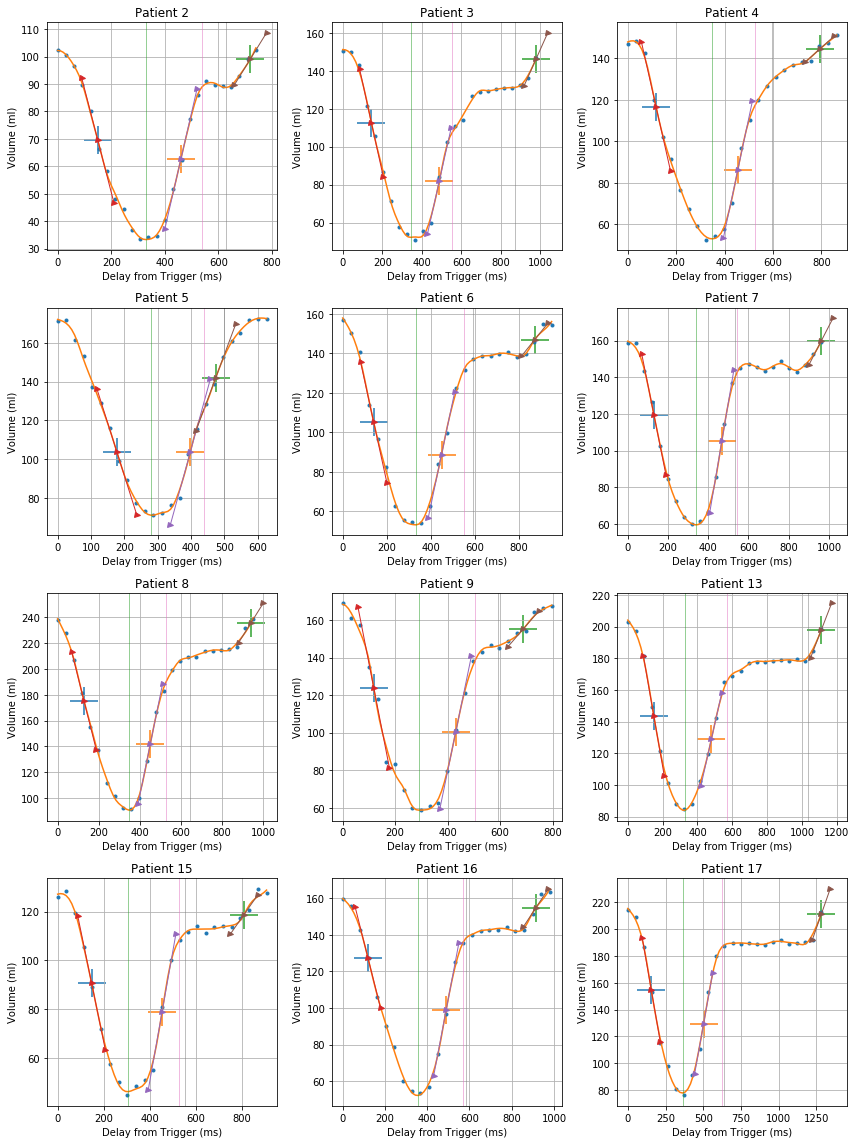

In [6]:
fig = plot_lv_param(patients)
fig.savefig('lv_results_healthy.png')

The final point is frequently identified as the maximum recovery because of the behaviour of the filtering at the end of interval. We've tweaked the boundary mode in SG to try and minimise this - a combination of `interp` and `mirror` seems to be the most robust.

In [7]:
def plot_lv_slopes(patients, region='LV'):
    npats = len(patients)
    ncols = 3
    nrows = int(np.ceil(npats / ncols))
    units, time_units = 'ml', 'ms'

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

    for (key, patient), ax in zip(sorted(patients.items()), axs.flat):
        patient_name = patient.pat_name
        volume_series = patient[region]
        times = np.asarray(volume_series.index)
        volumes = np.asarray(volume_series.values) 
        diffs = np.gradient(volumes) / np.diff(times)[0]
        r_to_r = times[-1]

        lvparams = LVAnalysis(volumes, times, name='%s %s' % (patient_name, region))

        ax.plot(times, diffs, '.')
        ax.plot(lvparams.times, lvparams.derivatives, '-')
        ax.grid(True)
        ax.set_xlabel('Delay from Trigger (%s)' % time_units)
        ax.set_ylabel('Filling Rate (%s)' % 'ml/ms')
        ax.set_title(patient_name)

        # end systole
        ax.axvline(lvparams.es_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])

        # maximum slopes
        ax.scatter(
            [lvparams.emptying_time, lvparams.early_filling_time, lvparams.late_filling_time],
            [lvparams.emptying_slope, lvparams.early_filling_slope, lvparams.late_filling_slope],
            s=750, marker='+'
        )

        # shoulder refill times
        ax.axvline(lvparams.shoulder_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])
    for i in range(len(patients), len(axs.flat)):
        axs.flat[i].axis('off')
    fig.set_tight_layout(True)
    return fig

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Second filling peak not found in Patient 5 LV - falling back to argmax.


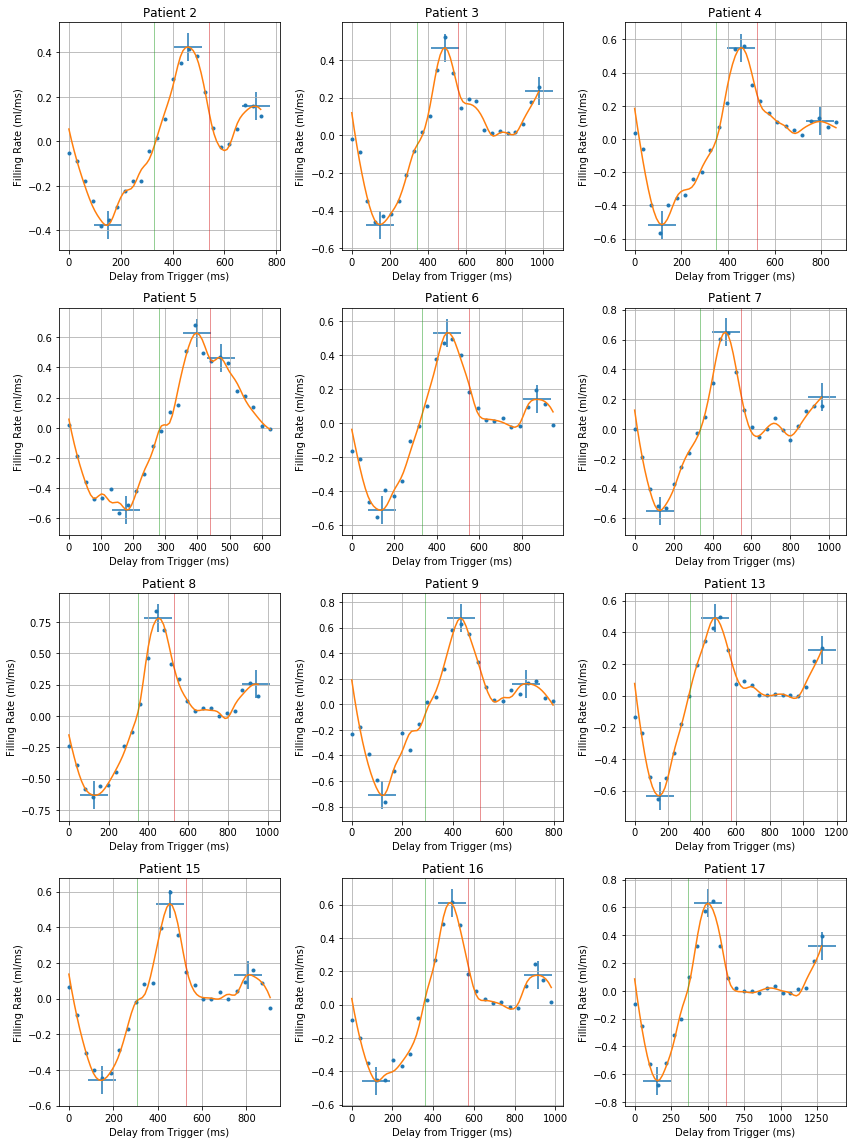

In [8]:
fig = plot_lv_slopes(patients)
fig.savefig('lv_slopes_healthy.png')

### Slope and acceleration curves for a single patient

In [9]:
def plot_single_patient_lv(patient, region='LV'):
    units, time_units = 'ml', 'ms'

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    patient_name = patient.pat_name
    volume_series = patient[region]
    times = np.asarray(volume_series.index)
    volumes = np.asarray(volume_series.values) 
    diffs = np.gradient(volumes) / np.diff(times)[0]
    r_to_r = times[-1]

    lvparams = LVAnalysis(volumes, times, name='%s %s' % (patient_name, region))

    ax[0].plot(times, volumes, '.')
    ax[0].plot(lvparams.times, lvparams.volumes, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)
    ax[0].set_title('Volume')

    # end systole
    ax[0].axvline(lvparams.es_time, lw=0.5, color=next(ax[0]._get_lines.prop_cycler)['color'])

    # maximum slopes
    plot_tangent((lvparams.emptying_time, lvparams.emptying_vol), slope=lvparams.emptying_slope, axes=ax[0])
    plot_tangent((lvparams.early_filling_time, lvparams.early_filling_vol), slope=lvparams.early_filling_slope, axes=ax[0])
    plot_tangent((lvparams.late_filling_time, lvparams.late_filling_vol), slope=lvparams.late_filling_slope, axes=ax[0])

    # shoulder and 80% refill times
    ax[0].axvline(lvparams.shoulder_time, lw=0.5, color=next(ax[0]._get_lines.prop_cycler)['color'])
    ax[0].axvline(lvparams.refill80_time, lw=0.5, color=next(ax[0]._get_lines.prop_cycler)['color'])    
    
    
    ax[1].plot(times, diffs, '.')
    ax[1].plot(lvparams.times, lvparams.derivatives, '-')
    ax[1].grid(True)
    ax[1].axvline(lvparams.es_time, lw=0.5, color=next(ax[1]._get_lines.prop_cycler)['color'])
    ax[1].axvline(lvparams.shoulder_time, lw=0.5, color=next(ax[1]._get_lines.prop_cycler)['color'])
    ax[1].axvline(lvparams.refill80_time, lw=0.5, color=next(ax[1]._get_lines.prop_cycler)['color'])  
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Filling Rate (%s)' % 'ml/ms')    
    ax[1].set_title('Flow')

    ax[2].plot(times, np.gradient(diffs)/ np.diff(times)[0], '.')
    ax[2].plot(lvparams.times, lvparams.accels, '-')
    ax[2].grid(True)
    ax[2].axvline(lvparams.es_time, lw=0.5, color=next(ax[2]._get_lines.prop_cycler)['color'])
    ax[2].axvline(lvparams.shoulder_time, lw=0.5, color=next(ax[2]._get_lines.prop_cycler)['color'])
    ax[2].axvline(lvparams.refill80_time, lw=0.5, color=next(ax[2]._get_lines.prop_cycler)['color'])  
    ax[2].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[2].set_ylabel('Filling Curvature (%s)' % 'ml/ms/ms')
    ax[2].set_title('Acceleration')

    fig.suptitle('%s' % patient_name, fontsize=14)

    fig.set_tight_layout(True)    


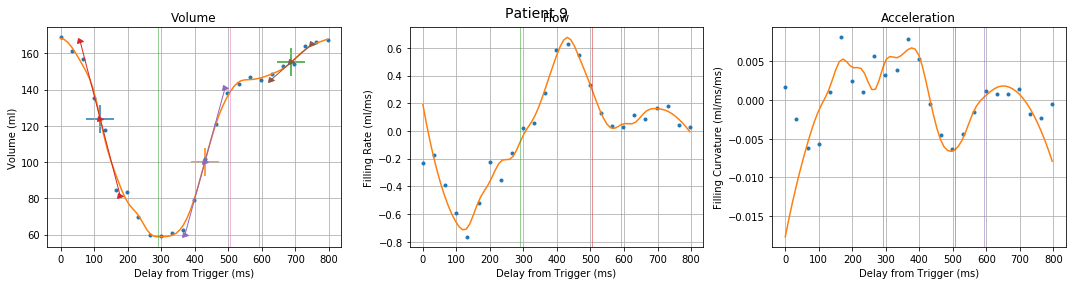

In [10]:
example_no = 9
plot_single_patient_lv(patients[example_no])

### Save numerical results to spreadsheet

In [11]:
def lv_results_dict(patients, region='LV'):
    results = {}
    for key, patient in sorted(patients.items()):
        times = np.asarray(patient[region].index)
        volumes = np.asarray(patient[region].values) 
        lvparams = LVAnalysis(volumes, times, name='%s %s' % (patient.pat_name, region))
        results[key] = lvparams.summary()
    return results

df_results = pd.DataFrame.from_dict(lv_results_dict(patients), orient='index')
df_results.insert(0, 'RR_ms', df_times['RR'])

df_results.to_excel('lv_results_healthy.xlsx', sheet_name='LV', index_label='PatNo', float_format='%0.2f')

pd.set_option('precision', 2)
df_results.head(20).T

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Second filling peak not found in Patient 5 LV - falling back to argmax.


,2,3,4,5,6,7,8,9,13,15,16,17
RR_ms,770.71,1018.85,898.88,652.24,987.82,1000.33,993.05,829.76,1155.18,945.33,1021.10,1334.82
LV_time_end_systole,329.95,343.65,349.83,279.23,333.19,337.41,347.84,290.64,329.69,306.59,357.66,363.65
LV_peak_ejection_ml_sec,378.20,474.24,516.84,544.90,511.35,547.87,634.19,713.73,631.63,458.36,459.93,647.64
LV_time_peak_ejection,149.98,145.39,116.61,177.69,140.96,129.77,128.83,118.41,149.86,147.16,119.22,155.85
LV_vol_peak_ejection,69.49,112.58,116.71,103.57,105.01,119.57,174.92,123.86,143.37,90.80,127.55,154.57
LV_early_peak_filling_ml_sec,424.75,465.12,550.61,628.00,530.41,648.70,779.76,675.77,491.47,532.73,609.71,629.94
LV_time_early_peak_filling,129.98,145.39,104.95,118.46,115.33,129.77,103.06,139.94,149.86,147.16,132.47,138.53
LV_vol_early_peak_filling,62.59,81.93,86.31,103.67,88.74,104.92,141.72,100.13,128.88,78.93,99.14,129.30
LV_late_peak_filling_ml_sec,158.15,232.85,105.17,463.08,139.14,212.96,254.92,161.43,285.31,134.91,175.80,321.65
LV_time_late_peak_filling,389.94,634.44,443.12,194.62,538.23,622.91,592.61,398.29,779.28,502.81,556.36,917.78
